### Evaluate

evaluation 코드

In [1]:
%load_ext autoreload
%autoreload 2

import _init_paths

from core.config import update_config
from core.config import config
from core.config import update_config
from core.config import update_dir
from core.config import get_model_name
from core.loss import JointsMSELoss
from core.function import train
from core.function import validate
from core.evaluate import *
from utils.utils import get_optimizer
from utils.utils import save_checkpoint
from utils.utils import create_logger

import dataset
import models

import torchvision.transforms as transforms
import torch

import matplotlib.pyplot as plt
import numpy as np

In [2]:
cd ..

/home/whikwon/Documents/github/human-pose-estimation.pytorch


In [3]:
update_config('./experiments/coco/resnet50/256x192_d256x3_adam_lr1e-3_medi.yaml')

In [4]:
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=True)

In [5]:
checkpoint_path = './output/medi/pose_resnet_101/256x192_d256x3_adam_lr1e-3_medi/2019-01-03-11-39/checkpoint.pth.tar'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

In [33]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
train_dataset = eval('dataset.'+config.DATASET.DATASET)(
    config,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]),
    False
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config.TRAIN.BATCH_SIZE,
    shuffle=config.TRAIN.SHUFFLE,
    num_workers=config.WORKERS,
    pin_memory=True
)

In [8]:
# cnt = 0
# for sample in train_loader:
#     for i in range(32):        
#         img = sample[0][i][0]
#         heatmap = sample[1][i][0]
        
#         plt.imsave(f'./debug/{cnt}_img.png', img)
#         plt.imsave(f'./debug/{cnt}_heatmap.png', heatmap)
        
#         cnt += 1

ValueError: Traceback (most recent call last):
  File "/home/whikwon/anaconda3/envs/simplebaseline/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/whikwon/anaconda3/envs/simplebaseline/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/whikwon/Documents/github/human-pose-estimation.pytorch/pose_estimation/../lib/dataset/medical.py", line 120, in __getitem__
    resized_new_bbox, heatmap = _make_resized_img_heatmap(new_bbox, new_kx_bbox, new_ky_bbox)
  File "/home/whikwon/Documents/github/human-pose-estimation.pytorch/pose_estimation/../lib/dataset/medical.py", line 116, in _make_resized_img_heatmap
    heatmap[hy1: hy2, hx1: hx2] = gaussian[gy:, gx:]
ValueError: could not broadcast input array from shape (5,5) into shape (0,5)


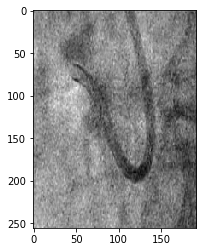

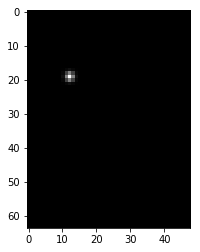

In [34]:
sample = iter(train_loader).next()

plt.imshow(sample[0][4][0], cmap='gray')
plt.show()
plt.imshow(sample[1][4][0], cmap='gray')
plt.show()

In [10]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])
test_dataset = eval('dataset.'+config.DATASET.DATASET)(
    config,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]),
    False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.TEST.BATCH_SIZE,
    shuffle=True,
    num_workers=config.WORKERS,
    pin_memory=True
)

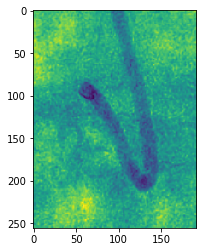

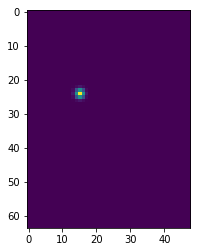

In [11]:
sample = iter(test_loader).next()

plt.imshow(sample[0][0][0])
plt.show()
plt.imshow(sample[1][0][0])
plt.show()

inference

In [12]:
imgs = sample[0]

In [13]:
targets = sample[1]

In [14]:
outputs = model(imgs)

In [15]:
outputs.shape

torch.Size([32, 1, 64, 48])

In [16]:
acc, avg_acc, cnt, pred = accuracy(outputs.data.cpu().numpy(), targets.numpy())

In [19]:
def save_interm_result(imgs, outputs, targets, save_dir):
    """Save intermediate result during training

    Args:
        imgs (torch.Tensor): [batch_size, n_channel, width, height]
        targets (torch.Tensor): [batch_size, n_bbox, 5]
        save_dir (str): directory saving intermediate result
        curr_epoch (int): current epoch number
    """
    def _denormalize_img(img):
        return (img*127.5) + 127.5
    
    num_imgs = len(imgs)
    img_size = imgs.shape[-2], imgs.shape[-1]
    output_size = outputs.shape[-2], outputs.shape[-1]

    num_rows = math.ceil(num_imgs**0.5)
    num_cols = round(num_imgs**0.5)

    img_mask = np.zeros([img_size[0]*num_rows, img_size[1]*num_cols])
    output_mask = np.zeros([output_size[0]*num_rows, output_size[1]*num_cols])
    target_mask = np.zeros([output_size[0]*num_rows, output_size[1]*num_cols])
    
    imgs_arr = imgs.cpu().data.numpy()[:, 0, :, :]
    targets_arr = targets.cpu().data.numpy()[:, 0, :, :]
    outputs_arr = outputs.cpu().data.numpy()[:, 0, :, :]
    
    os.makedirs(save_dir, exist_ok=True)

    for i, (img, target, output) in enumerate(zip(imgs_arr, targets_arr, outputs_arr)):
            row = i // num_cols
            col = i % num_cols
            img_mask[row*img_size[0]: (row+1)*img_size[0], col*img_size[1]:(col+1)*img_size[1]] = img.copy()
            output_mask[row*output_size[0]: (row+1)*output_size[0], col*output_size[1]:(col+1)*output_size[1]] = output.copy()
            target_mask[row*output_size[0]: (row+1)*output_size[0], col*output_size[1]:(col+1)*output_size[1]] = target.copy()
    
    
    for i, mask in enumerate([img_mask, output_mask, target_mask]):
        save_path = os.path.join(save_dir, f'{i}.jpg')
        cv2.imwrite(save_path, _denormalize_img(mask))
        print(save_path)
    return img_mask, output_mask, target_mask


In [20]:
pwd

'/home/whikwon/Documents/github/human-pose-estimation.pytorch'

In [21]:
import math
import os
import cv2

In [22]:
save_dir = '/home/whikwon/Documents/github/human-pose-estimation.pytorch/output/medi/pose_resnet_101'
img_mask, output_mask, target_mask = save_interm_result(imgs, outputs, targets, save_dir)

/home/whikwon/Documents/github/human-pose-estimation.pytorch/output/medi/pose_resnet_101/0.jpg
/home/whikwon/Documents/github/human-pose-estimation.pytorch/output/medi/pose_resnet_101/1.jpg
/home/whikwon/Documents/github/human-pose-estimation.pytorch/output/medi/pose_resnet_101/2.jpg


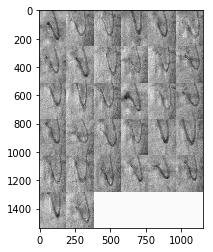

In [23]:
plt.imshow(img_mask, cmap='gray')

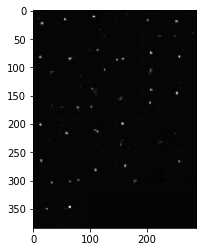

In [24]:
plt.imshow(output_mask, cmap='gray')

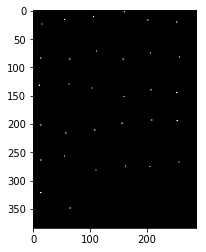

In [25]:
plt.imshow(target_mask, cmap='gray')